In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "../data/market-price.csv"
bitcoin_df = pd.read_csv(file_path, names=['day','price'])

print(bitcoin_df.shape)
print(bitcoin_df.info)
bitcoin_df.tail()

(365, 2)
<bound method DataFrame.info of                      day        price
0    2017-08-27 00:00:00  4354.308333
1    2017-08-28 00:00:00  4391.673517
2    2017-08-29 00:00:00  4607.985450
3    2017-08-30 00:00:00  4594.987850
4    2017-08-31 00:00:00  4748.255000
..                   ...          ...
360  2018-08-22 00:00:00  6575.229167
361  2018-08-23 00:00:00  6434.881667
362  2018-08-24 00:00:00  6543.645714
363  2018-08-25 00:00:00  6719.429231
364  2018-08-26 00:00:00  6673.274167

[365 rows x 2 columns]>


,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


In [13]:
#디테일한 시간을 그냥 day로 바꿔주기
#날짜 다루는 함수
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

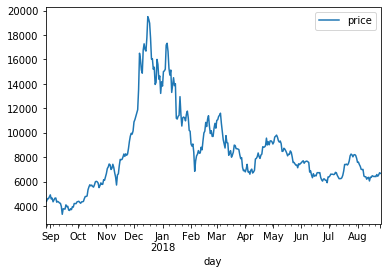

In [14]:
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day',inplace=True) # index 지정해주기

bitcoin_df.plot()
plt.show() #알아서 시간데이터있으면 시계열로 예측해줌

In [15]:
#ARIMA 모델 활용하기
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model = ARIMA(bitcoin_df.price.values,order=(2,1,2))
model_fit = model.fit(trend="c",full_output = True, disp=True)
print(model_fit.summary()) #모델적합성보기

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.553
Method:                       css-mle   S.D. of innovations            512.415
Date:                Tue, 09 Jun 2020   AIC                           5587.107
Time:                        21:21:55   BIC                           5610.490
Sample:                             1   HQIC                          5596.400
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3289     27.794      0.228      0.820     -48.146      60.804
ar.L1.D.y     -0.3786      1.824     -0.208      0.836      -3.954       3.197
ar.L2.D.y      0.1587      1.189      0.133      0.8

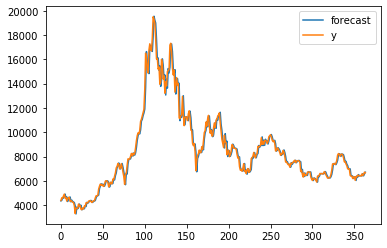

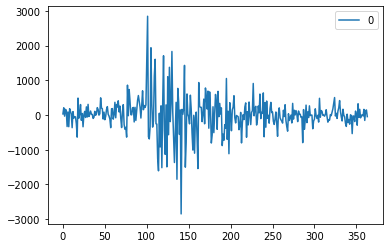

In [17]:
fig = model_fit.plot_predict() #학습데이터에 대한 예측결과 #모델 생성
residuals = pd.DataFrame(model_fit.resid) #잔차 그래프
residuals.plot()

In [19]:
#arima 모델 성능보기 #미래데이터 예측이 얼마만큼 평가되었는지 살펴보기
forecast_data = model_fit.forecast(steps=5)

forecast_data #여러개의 다중행렬로 나옴

(array([6676.89300118, 6684.99955021, 6690.22537591, 6697.25400611,
        6703.14294951]),
 array([ 512.41529824,  753.50485172,  914.97837094, 1061.45336423,
        1184.43847986]),
 array([[5672.5774715 , 7681.20853086],
        [5208.15717866, 8161.84192176],
        [4896.90072223, 8483.55002959],
        [4616.84364094, 8777.66437128],
        [4381.68618708, 9024.59971195]]))

In [11]:
test_file_path = "../data/market-price-test.csv"
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds','y'])

pred_y = forecast_data[0].tolist()
test_y = bitcoin_test_df.y.values

pred_y_lower = []
pred_y_upper = []

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

KeyError: 0

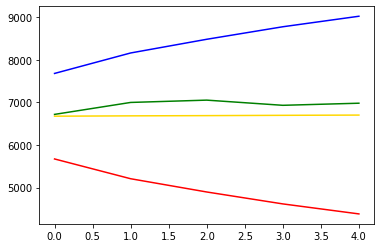

In [22]:
plt.plot(pred_y,color="gold")
plt.plot(pred_y_lower,color="red")
plt.plot(pred_y_upper,color="blue")
plt.plot(test_y,color="green")

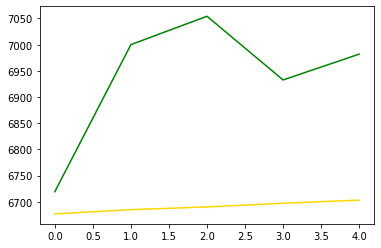

In [23]:
plt.plot(pred_y,color="gold")
plt.plot(test_y,color="green")

In [5]:
from fbprophet import Prophet

bitcoin_df = pd.read_csv(file_path,names=['ds','y'])

In [4]:
prophet = Prophet(seasonality_mode = "multiplicative",
                 yearly_seasonality = True,
                 weekly_seasonality = True, daily_seasonality = True,
                 changepoint_prior_scale = 0.5)
prophet.fit(bitcoin_df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [6]:
future_data = prophet.make_future_dataframe(periods=5,freq="d")
forecast_data = prophet.predict(future_data)
forecast_data[['ds','yhat','yhat_lower','yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6882.306915,6237.258442,7540.251262
366,2018-08-28,6976.002532,6306.123117,7644.880970
367,2018-08-29,6986.465207,6230.380151,7709.799932
368,2018-08-30,7055.474837,6318.099341,7780.810942
369,2018-08-31,7133.441748,6390.637154,7932.691303


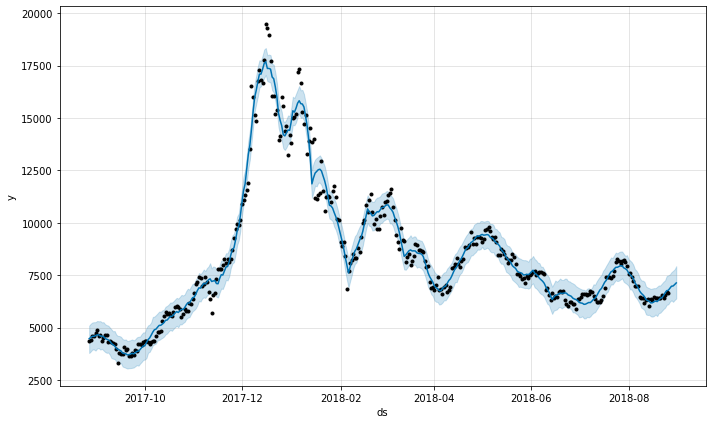

In [7]:
fig1 = prophet.plot(forecast_data)

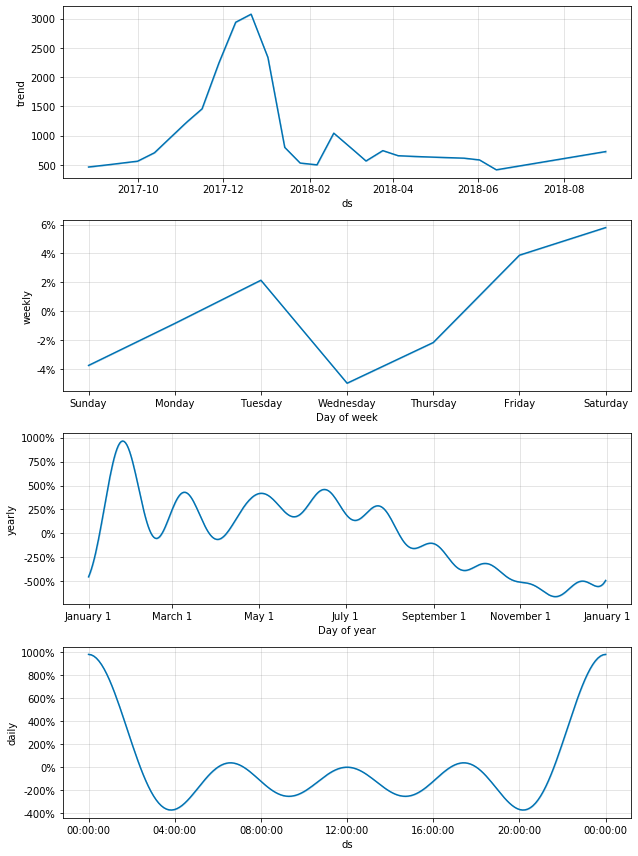

In [8]:
fig2 = prophet.plot_components(forecast_data)

In [16]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds','v'])

bitcoin_test_df[-5:]

,ds,v
0,2018-08-27 00:00:00,6719.266154
1,2018-08-28 00:00:00,7000.040000
2,2018-08-29 00:00:00,7054.276429
3,2018-08-30 00:00:00,6932.662500
4,2018-08-31 00:00:00,6981.946154


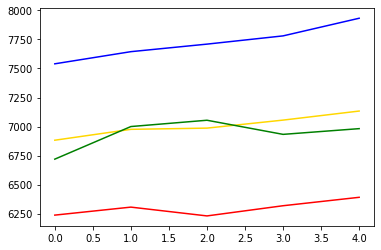

In [18]:
#마지막 5일의 예측 데이터
pred_y = forecast_data.yhat.values[-5:]
#실제 5일 가격 데이터
test_y = bitcoin_test_df.v.values
#마지막 5일 예측데이터 최솟값.
pred_y_lower = forecast_data.yhat_lower.values[-5:]
#마지막 5일 예측데이터 최댓값
pred_y_upper = forecast_data.yhat_upper.values[-5:]

#모델이 예상한 가격그래프
plt.plot(pred_y,color="gold")
plt.plot(pred_y_lower,color="red")
plt.plot(pred_y_upper,color="blue")
plt.plot(test_y, color="green")

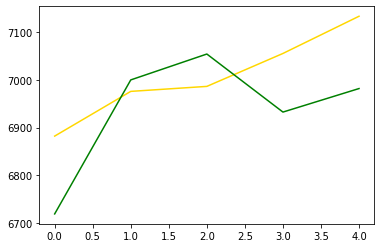

In [19]:
plt.plot(pred_y,color="gold")
plt.plot(test_y,color="green")

In [24]:
#RMSE 비교하기
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
rmse = math.sqrt(mean_squared_error(pred_y,test_y))
print(rmse)

118.14587298999649


In [31]:
#STEP3 상한가 및 하한가 설정하기
bitcoin_df = pd.read_csv(file_path, names=['ds','y'])
bitcoin_df

,ds,y
0,2017-08-27 00:00:00,4354.308333
1,2017-08-28 00:00:00,4391.673517
2,2017-08-29 00:00:00,4607.985450
3,2017-08-30 00:00:00,4594.987850
4,2017-08-31 00:00:00,4748.255000
...,...,...
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231


In [26]:
bitcoin_df['cap'] = 20000 #상한가 설정하기

In [28]:
#상한가 적용을 위헤서 모델 파라미터 설정해주기
prophet = Prophet(seasonality_mode="multiplicative",
                 growth = "logistic", yearly_seasonality = True,
                 weekly_seasonality = True, daily_seasonality = True,
                 changepoint_prior_scale = 0.5)
prophet.fit(bitcoin_df)

In [30]:
future_data = prophet.make_future_dataframe(periods = 5, freq= "d") #5일 내다보며 에측하기
future_data

,ds
0,2017-08-27
1,2017-08-28
2,2017-08-29
3,2017-08-30
4,2017-08-31
...,...
365,2018-08-27
366,2018-08-28
367,2018-08-29
368,2018-08-30


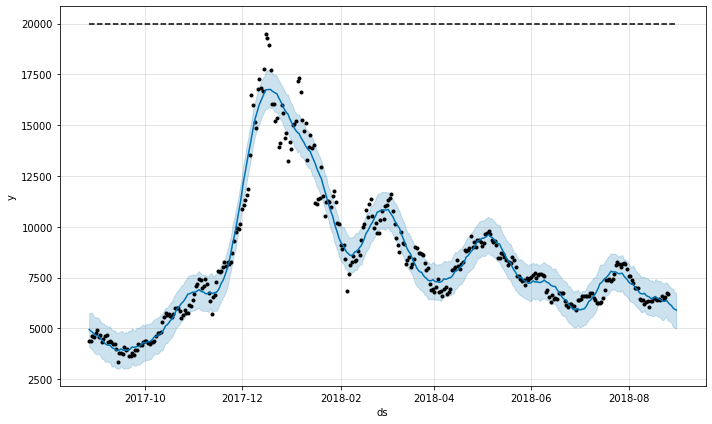

In [32]:
#상한가 설정
future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

fig  = prophet.plot(forecast_data)

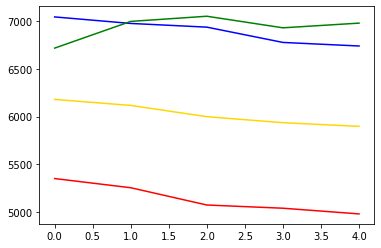

In [36]:
#예측과 실제비교 그래프
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds','y'])
#모델이 예측한 마지막 5일의 가격데이터를 가져오기
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y,color="gold")
plt.plot(pred_y_lower,color="red")
plt.plot(pred_y_upper,color="blue")
plt.plot(test_y, color="green")

In [41]:
#이상치 제거해준다음에 분석하기 : 이상치 18000으로 설정
bitcoin_df = pd.read_csv(file_path, names=["ds","y"])
bitcoin_df.loc[bitcoin_df['y'] > 18000,  'y'] = None

#prophet 모델 학습하기
prophet = Prophet(seasonality_mode="multiplicative",
                 yearly_seasonality=True, weekly_seasonality = True,
                 daily_seasonality = True, changepoint_prior_scale = 0.5)
prophet.fit(bitcoin_df)

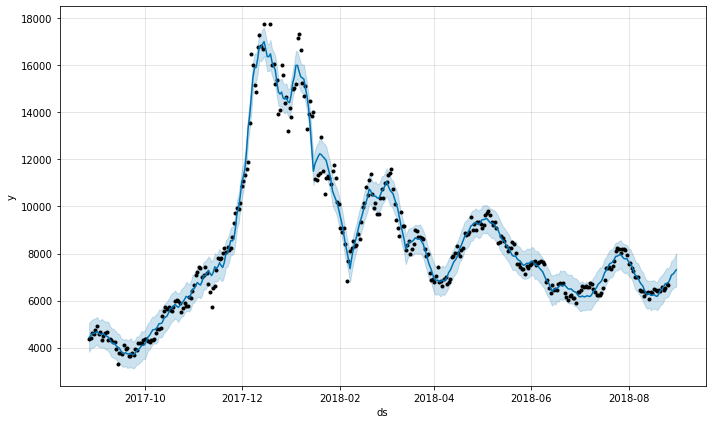

In [38]:
#5일단위의 미래 예측하기
future_data = prophet.make_future_dataframe(periods=5,freq="d")
forecast_data = prophet.predict(future_data)

#예측결과를 그래프로 출력
fig = prophet.plot(forecast_data)

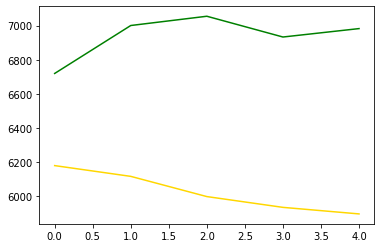

In [42]:
plt.plot(pred_y,color="gold")
plt.plot(test_y,color="green")

In [40]:
#rmse 계산
rmse = sqrt(mean_squared_error(pred_y,test_y))
print(rmse)

933.6503856863973
